In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "7"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 1000.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(f"trg_idx = {trg_idx}, lambda_id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
trg_idx = 0, lambda_id = 1000.0


Computing l1 cost


591it [00:28, 20.58it/s]


l1 cost = 0.019531133421365685, best l1 cost = 0.019531133421365685, best iter = 96000
Computing l2 cost


591it [00:28, 20.65it/s]


l2 cost = 0.0008150927855500153, best l2 cost = 0.0008150927855500153, best iter = 96000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.17it/s]


FID = 140.27250128368627, best FID = 140.202944812368, best iter = 48000
FID = 140.27250128368627, best FID = 140.202944812368, best iter = 48000
Plotting, iter = 96000
mode = train


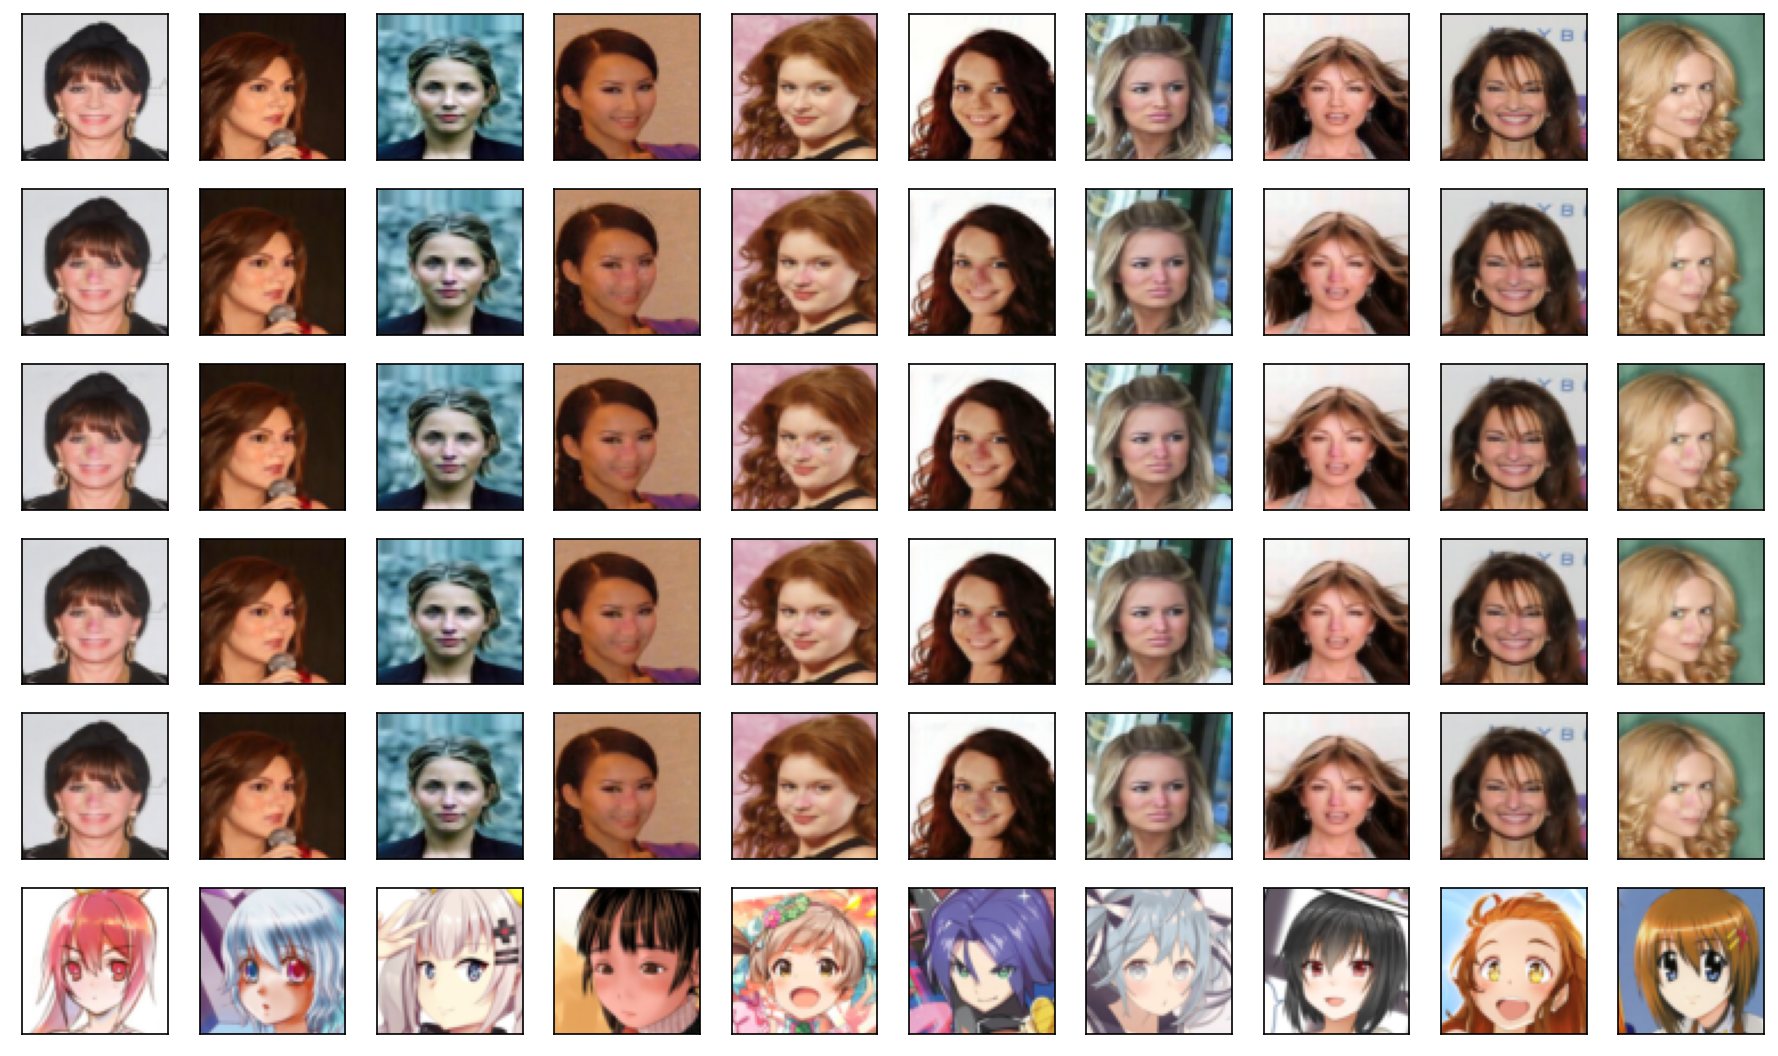

mode = test


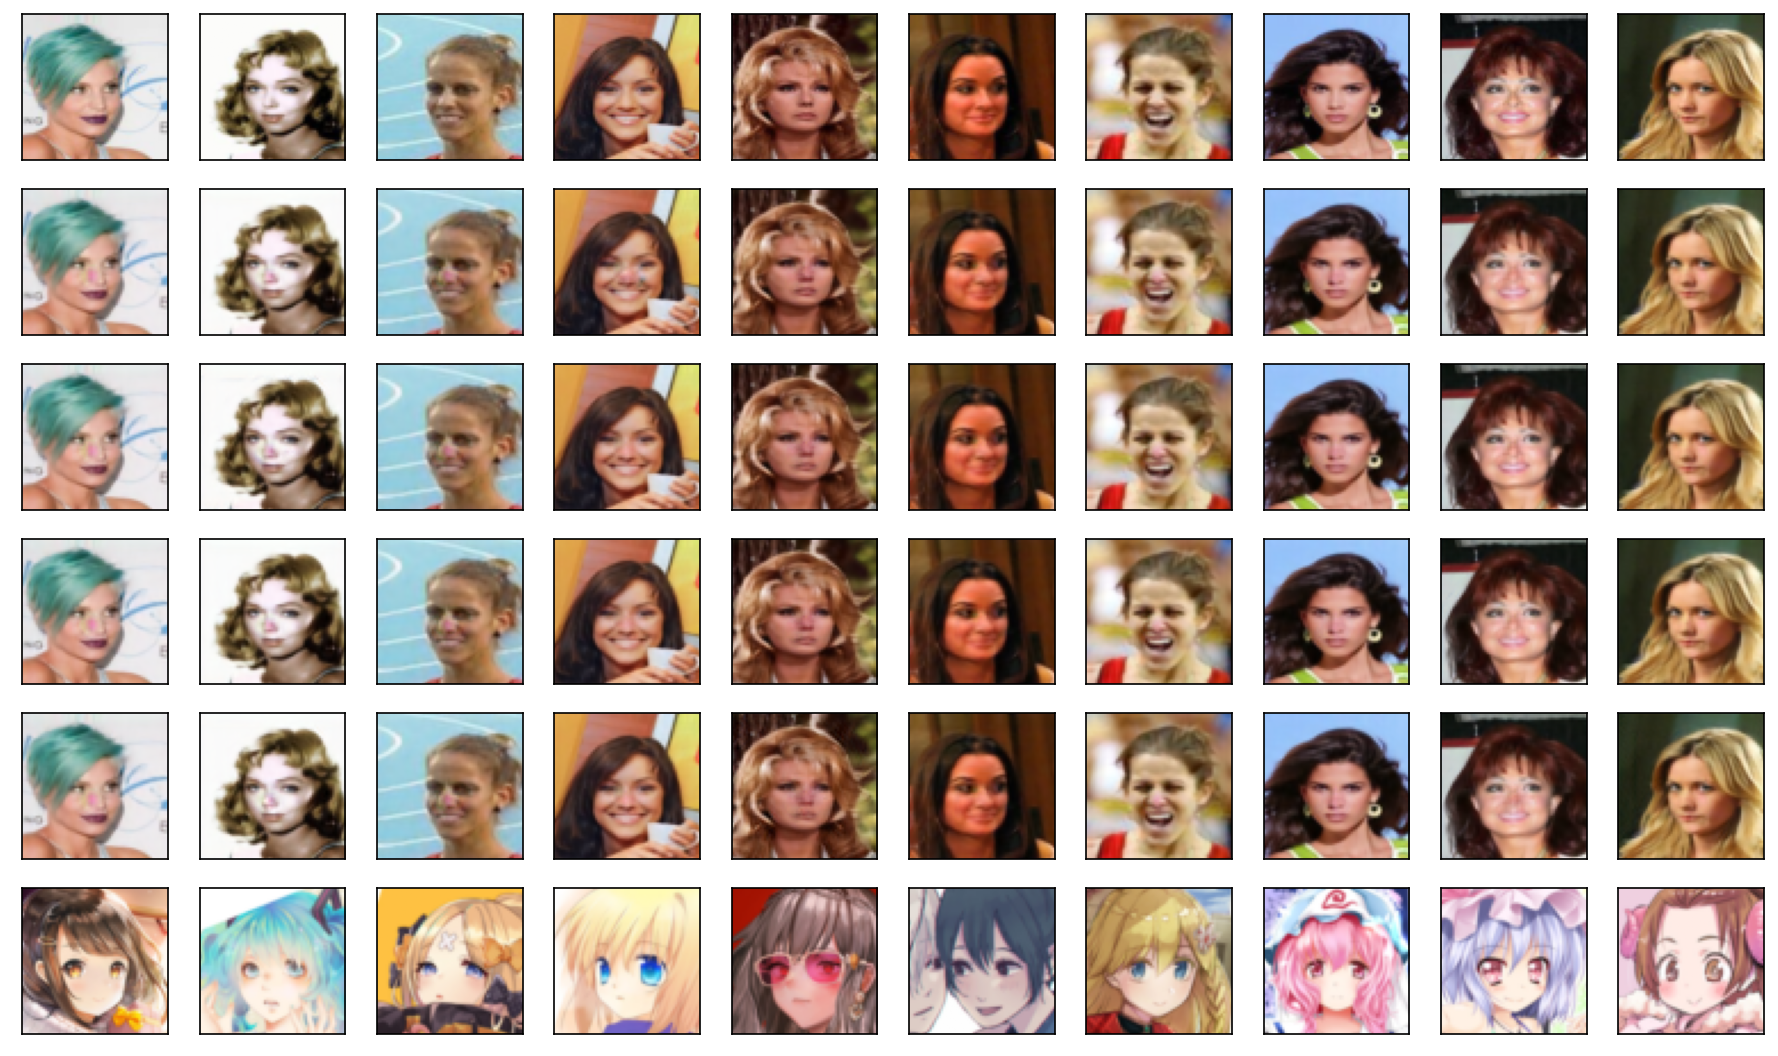

G loss = 31.57583236694336, d loss = 1.0274046659469604, lambda_id = 1000.0
G loss = 30.67937469482422, d loss = 0.9149131178855896, lambda_id = 1000.0
G loss = 31.541446685791016, d loss = 0.922588050365448, lambda_id = 1000.0
G loss = 31.13345718383789, d loss = 0.9803791046142578, lambda_id = 1000.0
G loss = 33.42671203613281, d loss = 0.9447894096374512, lambda_id = 1000.0
G loss = 35.24894332885742, d loss = 0.7817237377166748, lambda_id = 1000.0
G loss = 31.332141876220703, d loss = 1.1175404787063599, lambda_id = 1000.0
G loss = 27.779756546020508, d loss = 0.9865967035293579, lambda_id = 1000.0
G loss = 27.206079483032227, d loss = 1.0447129011154175, lambda_id = 1000.0
G loss = 32.53525924682617, d loss = 0.8481847047805786, lambda_id = 1000.0
Elapsed time [1 day, 5:52:20], Iteration [96011/100000], D/latent_real: [0.4278] D/latent_fake: [0.3377] D/latent_reg: [0.0677] D/ref_real: [0.2834] D/ref_fake: [0.5076] D/ref_reg: [0.0572] G/latent_adv: [3.2572] G/latent_sty: [0.2767] G

G loss = 32.09548568725586, d loss = 0.9235715866088867, lambda_id = 1000.0
G loss = 38.27018356323242, d loss = 1.0483956336975098, lambda_id = 1000.0
G loss = 35.60467529296875, d loss = 1.117423176765442, lambda_id = 1000.0
G loss = 34.196441650390625, d loss = 1.0451375246047974, lambda_id = 1000.0
G loss = 34.8513298034668, d loss = 0.7080294489860535, lambda_id = 1000.0
G loss = 30.172426223754883, d loss = 0.9886771440505981, lambda_id = 1000.0
G loss = 31.603862762451172, d loss = 0.9099304676055908, lambda_id = 1000.0
Elapsed time [1 day, 5:53:36], Iteration [96081/100000], D/latent_real: [0.3539] D/latent_fake: [0.5589] D/latent_reg: [0.0833] D/ref_real: [0.4335] D/ref_fake: [0.4025] D/ref_reg: [0.0739] G/latent_adv: [2.4657] G/latent_sty: [0.2965] G/latent_ds: [0.0060] G/latent_cyc: [0.0473] G/ref_adv: [1.8432] G/ref_sty: [0.1386] G/ref_ds: [0.0066] G/ref_cyc: [0.0992] G/lambda_ds: [0.0392]
G loss = 31.032047271728516, d loss = 0.8814752101898193, lambda_id = 1000.0
G loss =

G loss = 36.61504364013672, d loss = 0.893147885799408, lambda_id = 1000.0
G loss = 28.11838150024414, d loss = 0.697799563407898, lambda_id = 1000.0
G loss = 32.17493438720703, d loss = 0.8364856839179993, lambda_id = 1000.0
G loss = 32.399723052978516, d loss = 1.0157545804977417, lambda_id = 1000.0
Elapsed time [1 day, 5:54:52], Iteration [96151/100000], D/latent_real: [0.2931] D/latent_fake: [0.7376] D/latent_reg: [0.0562] D/ref_real: [0.5733] D/ref_fake: [0.3854] D/ref_reg: [0.0570] G/latent_adv: [2.2258] G/latent_sty: [0.2557] G/latent_ds: [0.0055] G/latent_cyc: [0.0481] G/ref_adv: [1.6803] G/ref_sty: [0.1035] G/ref_ds: [0.0146] G/ref_cyc: [0.0749] G/lambda_ds: [0.0385]
G loss = 31.63442611694336, d loss = 0.9362148642539978, lambda_id = 1000.0
G loss = 30.489593505859375, d loss = 0.9298014640808105, lambda_id = 1000.0
G loss = 31.05742645263672, d loss = 0.890078604221344, lambda_id = 1000.0
G loss = 32.978919982910156, d loss = 0.846923291683197, lambda_id = 1000.0
G loss = 33

G loss = 37.1800537109375, d loss = 0.8426114916801453, lambda_id = 1000.0
Elapsed time [1 day, 5:56:08], Iteration [96221/100000], D/latent_real: [0.4859] D/latent_fake: [0.3548] D/latent_reg: [0.0745] D/ref_real: [0.2987] D/ref_fake: [0.4800] D/ref_reg: [0.0639] G/latent_adv: [3.1741] G/latent_sty: [0.2902] G/latent_ds: [0.0063] G/latent_cyc: [0.0509] G/ref_adv: [2.3910] G/ref_sty: [0.1771] G/ref_ds: [0.0071] G/ref_cyc: [0.0982] G/lambda_ds: [0.0378]
G loss = 33.5302848815918, d loss = 0.7620798349380493, lambda_id = 1000.0
G loss = 30.869028091430664, d loss = 1.1164584159851074, lambda_id = 1000.0
G loss = 37.36745071411133, d loss = 0.9737281799316406, lambda_id = 1000.0
G loss = 31.41918182373047, d loss = 0.8650346994400024, lambda_id = 1000.0
G loss = 31.098236083984375, d loss = 0.9984415173530579, lambda_id = 1000.0
G loss = 29.480730056762695, d loss = 1.0752794742584229, lambda_id = 1000.0
G loss = 29.91157341003418, d loss = 0.9510838389396667, lambda_id = 1000.0
G loss = 

G loss = 34.640174865722656, d loss = 0.9368440508842468, lambda_id = 1000.0
G loss = 35.45405578613281, d loss = 0.9721969366073608, lambda_id = 1000.0
G loss = 33.57759094238281, d loss = 0.9731255173683167, lambda_id = 1000.0
G loss = 32.721221923828125, d loss = 0.7949725389480591, lambda_id = 1000.0
G loss = 32.44769287109375, d loss = 0.8547511696815491, lambda_id = 1000.0
G loss = 36.449928283691406, d loss = 0.8257865309715271, lambda_id = 1000.0
G loss = 32.38784408569336, d loss = 0.8768197298049927, lambda_id = 1000.0
G loss = 33.895591735839844, d loss = 1.062975525856018, lambda_id = 1000.0
G loss = 31.4215145111084, d loss = 0.9018104076385498, lambda_id = 1000.0
G loss = 34.45083999633789, d loss = 1.0070778131484985, lambda_id = 1000.0
Elapsed time [1 day, 5:57:35], Iteration [96301/100000], D/latent_real: [0.3884] D/latent_fake: [0.5533] D/latent_reg: [0.0780] D/ref_real: [0.4930] D/ref_fake: [0.4408] D/ref_reg: [0.0733] G/latent_adv: [2.0780] G/latent_sty: [0.2973] G/

G loss = 34.58442687988281, d loss = 0.7522544860839844, lambda_id = 1000.0
G loss = 33.629600524902344, d loss = 0.8679805994033813, lambda_id = 1000.0
G loss = 28.219589233398438, d loss = 1.0987199544906616, lambda_id = 1000.0
G loss = 32.97038269042969, d loss = 0.978878378868103, lambda_id = 1000.0
G loss = 25.743850708007812, d loss = 1.2641078233718872, lambda_id = 1000.0
G loss = 35.94847106933594, d loss = 1.0616775751113892, lambda_id = 1000.0
G loss = 31.1245059967041, d loss = 1.1029402017593384, lambda_id = 1000.0
Elapsed time [1 day, 5:58:51], Iteration [96371/100000], D/latent_real: [0.3103] D/latent_fake: [0.8250] D/latent_reg: [0.0644] D/ref_real: [0.5958] D/ref_fake: [0.4357] D/ref_reg: [0.0714] G/latent_adv: [1.5539] G/latent_sty: [0.2694] G/latent_ds: [0.0051] G/latent_cyc: [0.0484] G/ref_adv: [1.0997] G/ref_sty: [0.1612] G/ref_ds: [0.0053] G/ref_cyc: [0.0887] G/lambda_ds: [0.0363]
G loss = 30.078081130981445, d loss = 0.8307069540023804, lambda_id = 1000.0
G loss =

G loss = 34.38670349121094, d loss = 0.7067013382911682, lambda_id = 1000.0
G loss = 31.532974243164062, d loss = 0.9499458074569702, lambda_id = 1000.0
G loss = 32.11079788208008, d loss = 0.9593698382377625, lambda_id = 1000.0
G loss = 33.89744567871094, d loss = 1.233986735343933, lambda_id = 1000.0
Elapsed time [1 day, 6:00:07], Iteration [96441/100000], D/latent_real: [0.3873] D/latent_fake: [0.7480] D/latent_reg: [0.0724] D/ref_real: [0.8467] D/ref_fake: [0.3193] D/ref_reg: [0.0679] G/latent_adv: [1.4948] G/latent_sty: [0.2954] G/latent_ds: [0.0070] G/latent_cyc: [0.0517] G/ref_adv: [1.0666] G/ref_sty: [0.1404] G/ref_ds: [0.0111] G/ref_cyc: [0.0910] G/lambda_ds: [0.0356]
G loss = 29.318313598632812, d loss = 1.0146872997283936, lambda_id = 1000.0
G loss = 36.22978591918945, d loss = 0.8045849800109863, lambda_id = 1000.0
G loss = 29.650257110595703, d loss = 0.8495103716850281, lambda_id = 1000.0
G loss = 36.9610481262207, d loss = 0.8299426436424255, lambda_id = 1000.0
G loss = 

G loss = 30.807458877563477, d loss = 1.0436557531356812, lambda_id = 1000.0
Elapsed time [1 day, 6:01:23], Iteration [96511/100000], D/latent_real: [0.5253] D/latent_fake: [0.5308] D/latent_reg: [0.0659] D/ref_real: [0.4532] D/ref_fake: [0.5273] D/ref_reg: [0.0632] G/latent_adv: [2.3434] G/latent_sty: [0.2455] G/latent_ds: [0.0063] G/latent_cyc: [0.0443] G/ref_adv: [1.9318] G/ref_sty: [0.1077] G/ref_ds: [0.0148] G/ref_cyc: [0.0743] G/lambda_ds: [0.0349]
G loss = 32.51365661621094, d loss = 0.6559867858886719, lambda_id = 1000.0
G loss = 30.49782371520996, d loss = 1.006640076637268, lambda_id = 1000.0
G loss = 37.038211822509766, d loss = 0.7610622048377991, lambda_id = 1000.0
G loss = 34.32798385620117, d loss = 0.730242908000946, lambda_id = 1000.0
G loss = 31.782699584960938, d loss = 0.7440124750137329, lambda_id = 1000.0
G loss = 32.240543365478516, d loss = 0.8853830099105835, lambda_id = 1000.0
G loss = 30.97284698486328, d loss = 1.0737718343734741, lambda_id = 1000.0
G loss =

G loss = 38.3509521484375, d loss = 0.5593270659446716, lambda_id = 1000.0
G loss = 36.45561218261719, d loss = 0.9593396782875061, lambda_id = 1000.0
G loss = 36.768558502197266, d loss = 0.9490789771080017, lambda_id = 1000.0
G loss = 31.199995040893555, d loss = 1.088350772857666, lambda_id = 1000.0
G loss = 28.466541290283203, d loss = 0.9483402967453003, lambda_id = 1000.0
G loss = 35.97150802612305, d loss = 0.8797796964645386, lambda_id = 1000.0
G loss = 30.599613189697266, d loss = 1.1508547067642212, lambda_id = 1000.0
G loss = 33.351402282714844, d loss = 1.014096736907959, lambda_id = 1000.0
G loss = 28.97217559814453, d loss = 1.0955709218978882, lambda_id = 1000.0
G loss = 29.85614776611328, d loss = 0.8722968697547913, lambda_id = 1000.0
Elapsed time [1 day, 6:02:50], Iteration [96591/100000], D/latent_real: [0.3745] D/latent_fake: [0.4998] D/latent_reg: [0.0555] D/ref_real: [0.4086] D/ref_fake: [0.4033] D/ref_reg: [0.0604] G/latent_adv: [2.9335] G/latent_sty: [0.2653] G/

G loss = 35.18284606933594, d loss = 1.0391494035720825, lambda_id = 1000.0
G loss = 38.58649826049805, d loss = 0.8014852404594421, lambda_id = 1000.0
G loss = 34.130680084228516, d loss = 1.0351133346557617, lambda_id = 1000.0
G loss = 32.06336975097656, d loss = 0.9002683162689209, lambda_id = 1000.0
G loss = 31.544239044189453, d loss = 1.174613118171692, lambda_id = 1000.0
G loss = 37.749515533447266, d loss = 1.1039429903030396, lambda_id = 1000.0
G loss = 33.624671936035156, d loss = 0.8205937743186951, lambda_id = 1000.0
Elapsed time [1 day, 6:04:06], Iteration [96661/100000], D/latent_real: [0.3625] D/latent_fake: [0.4044] D/latent_reg: [0.0549] D/ref_real: [0.3167] D/ref_fake: [0.4502] D/ref_reg: [0.0537] G/latent_adv: [3.0929] G/latent_sty: [0.2809] G/latent_ds: [0.0065] G/latent_cyc: [0.0454] G/ref_adv: [2.3323] G/ref_sty: [0.1950] G/ref_ds: [0.0133] G/ref_cyc: [0.0951] G/lambda_ds: [0.0334]
G loss = 30.354551315307617, d loss = 0.9904485940933228, lambda_id = 1000.0
G loss

G loss = 33.79190444946289, d loss = 1.0678980350494385, lambda_id = 1000.0
G loss = 34.1143913269043, d loss = 0.9095202684402466, lambda_id = 1000.0
G loss = 40.33373260498047, d loss = 0.9714984893798828, lambda_id = 1000.0
G loss = 37.60835266113281, d loss = 0.9278184175491333, lambda_id = 1000.0
Elapsed time [1 day, 6:05:22], Iteration [96731/100000], D/latent_real: [0.5246] D/latent_fake: [0.4117] D/latent_reg: [0.0753] D/ref_real: [0.3423] D/ref_fake: [0.5245] D/ref_reg: [0.0610] G/latent_adv: [2.5203] G/latent_sty: [0.3073] G/latent_ds: [0.0069] G/latent_cyc: [0.0575] G/ref_adv: [2.0399] G/ref_sty: [0.2118] G/ref_ds: [0.0169] G/ref_cyc: [0.0780] G/lambda_ds: [0.0327]
G loss = 32.30350112915039, d loss = 0.8090525269508362, lambda_id = 1000.0
G loss = 28.957651138305664, d loss = 1.0555078983306885, lambda_id = 1000.0
G loss = 37.30049133300781, d loss = 0.8091655373573303, lambda_id = 1000.0
G loss = 31.845680236816406, d loss = 0.8709763288497925, lambda_id = 1000.0
G loss = 

G loss = 31.218870162963867, d loss = 1.110800862312317, lambda_id = 1000.0
Elapsed time [1 day, 6:06:38], Iteration [96801/100000], D/latent_real: [0.4033] D/latent_fake: [0.7850] D/latent_reg: [0.0808] D/ref_real: [0.5408] D/ref_fake: [0.5129] D/ref_reg: [0.0571] G/latent_adv: [2.0574] G/latent_sty: [0.3169] G/latent_ds: [0.0062] G/latent_cyc: [0.0431] G/ref_adv: [1.3099] G/ref_sty: [0.1124] G/ref_ds: [0.0211] G/ref_cyc: [0.0858] G/lambda_ds: [0.0320]
G loss = 29.555810928344727, d loss = 0.9810945391654968, lambda_id = 1000.0
G loss = 29.25334358215332, d loss = 0.9441819787025452, lambda_id = 1000.0
G loss = 31.540081024169922, d loss = 1.0565458536148071, lambda_id = 1000.0
G loss = 34.76609802246094, d loss = 0.9322664737701416, lambda_id = 1000.0
G loss = 43.491573333740234, d loss = 0.936064600944519, lambda_id = 1000.0
G loss = 32.914154052734375, d loss = 0.9192787408828735, lambda_id = 1000.0
G loss = 33.334205627441406, d loss = 0.984189510345459, lambda_id = 1000.0
G loss 

G loss = 33.020973205566406, d loss = 0.913426399230957, lambda_id = 1000.0
G loss = 32.412628173828125, d loss = 0.9524019956588745, lambda_id = 1000.0
G loss = 29.449085235595703, d loss = 0.9157290458679199, lambda_id = 1000.0
G loss = 31.134868621826172, d loss = 1.0170458555221558, lambda_id = 1000.0
G loss = 33.23270797729492, d loss = 0.6116846203804016, lambda_id = 1000.0
G loss = 30.647502899169922, d loss = 1.0625919103622437, lambda_id = 1000.0
G loss = 32.366310119628906, d loss = 0.9138124585151672, lambda_id = 1000.0
G loss = 33.54021453857422, d loss = 0.9835137724876404, lambda_id = 1000.0
G loss = 35.85150146484375, d loss = 0.6551421284675598, lambda_id = 1000.0
G loss = 38.53824996948242, d loss = 0.9261593222618103, lambda_id = 1000.0
Elapsed time [1 day, 6:08:05], Iteration [96881/100000], D/latent_real: [0.2889] D/latent_fake: [0.6389] D/latent_reg: [0.0587] D/ref_real: [0.4280] D/ref_fake: [0.4413] D/ref_reg: [0.0569] G/latent_adv: [2.6777] G/latent_sty: [0.2590]

G loss = 33.18730926513672, d loss = 1.0139710903167725, lambda_id = 1000.0
G loss = 35.77433395385742, d loss = 0.8524268865585327, lambda_id = 1000.0
G loss = 35.118255615234375, d loss = 0.8218960165977478, lambda_id = 1000.0
G loss = 31.378034591674805, d loss = 1.0600965023040771, lambda_id = 1000.0
G loss = 36.67060089111328, d loss = 0.6957330703735352, lambda_id = 1000.0
G loss = 34.433197021484375, d loss = 0.9265600442886353, lambda_id = 1000.0
G loss = 35.55316925048828, d loss = 0.951781690120697, lambda_id = 1000.0
Elapsed time [1 day, 6:09:21], Iteration [96951/100000], D/latent_real: [0.3507] D/latent_fake: [0.5482] D/latent_reg: [0.0634] D/ref_real: [0.4730] D/ref_fake: [0.4107] D/ref_reg: [0.0681] G/latent_adv: [2.4182] G/latent_sty: [0.2954] G/latent_ds: [0.0074] G/latent_cyc: [0.0532] G/ref_adv: [1.5467] G/ref_sty: [0.2094] G/ref_ds: [0.0169] G/ref_cyc: [0.1012] G/lambda_ds: [0.0305]
G loss = 30.84185218811035, d loss = 0.8337626457214355, lambda_id = 1000.0
G loss =

G loss = 28.782180786132812, d loss = 1.0352154970169067, lambda_id = 1000.0
G loss = 37.0831413269043, d loss = 0.8816657662391663, lambda_id = 1000.0
G loss = 33.342010498046875, d loss = 0.8900666236877441, lambda_id = 1000.0
G loss = 35.02005386352539, d loss = 0.9116650819778442, lambda_id = 1000.0
Elapsed time [1 day, 6:10:37], Iteration [97021/100000], D/latent_real: [0.3320] D/latent_fake: [0.6552] D/latent_reg: [0.0602] D/ref_real: [0.4018] D/ref_fake: [0.4616] D/ref_reg: [0.0482] G/latent_adv: [2.7655] G/latent_sty: [0.2373] G/latent_ds: [0.0059] G/latent_cyc: [0.0492] G/ref_adv: [1.9523] G/ref_sty: [0.1486] G/ref_ds: [0.0389] G/ref_cyc: [0.1039] G/lambda_ds: [0.0298]
G loss = 30.655731201171875, d loss = 0.9817535281181335, lambda_id = 1000.0
G loss = 33.47016906738281, d loss = 0.9534473419189453, lambda_id = 1000.0
G loss = 30.42616081237793, d loss = 0.9721157550811768, lambda_id = 1000.0
G loss = 34.16243362426758, d loss = 0.8966351747512817, lambda_id = 1000.0
G loss =

G loss = 30.587207794189453, d loss = 0.9793389439582825, lambda_id = 1000.0
Elapsed time [1 day, 6:11:54], Iteration [97091/100000], D/latent_real: [0.3474] D/latent_fake: [0.6416] D/latent_reg: [0.0585] D/ref_real: [0.5018] D/ref_fake: [0.4156] D/ref_reg: [0.0619] G/latent_adv: [2.2884] G/latent_sty: [0.3047] G/latent_ds: [0.0059] G/latent_cyc: [0.0471] G/ref_adv: [2.0079] G/ref_sty: [0.1202] G/ref_ds: [0.0135] G/ref_cyc: [0.0701] G/lambda_ds: [0.0291]
G loss = 30.87140655517578, d loss = 0.9371920824050903, lambda_id = 1000.0
G loss = 35.849693298339844, d loss = 0.4977821409702301, lambda_id = 1000.0
G loss = 30.305442810058594, d loss = 1.1635369062423706, lambda_id = 1000.0
G loss = 102.02810668945312, d loss = 0.8742138743400574, lambda_id = 1000.0
G loss = 39.139678955078125, d loss = 1.0130449533462524, lambda_id = 1000.0
G loss = 29.984012603759766, d loss = 1.0066906213760376, lambda_id = 1000.0
G loss = 31.60394287109375, d loss = 1.0481536388397217, lambda_id = 1000.0
G lo

G loss = 32.21832275390625, d loss = 0.8456202745437622, lambda_id = 1000.0
G loss = 32.529537200927734, d loss = 0.8878551721572876, lambda_id = 1000.0
G loss = 34.10593795776367, d loss = 1.0073014497756958, lambda_id = 1000.0
G loss = 34.43067932128906, d loss = 0.5678287744522095, lambda_id = 1000.0
G loss = 34.20646667480469, d loss = 1.0089243650436401, lambda_id = 1000.0
G loss = 31.857616424560547, d loss = 0.7646893858909607, lambda_id = 1000.0
G loss = 32.87671661376953, d loss = 0.9118594527244568, lambda_id = 1000.0
G loss = 32.591217041015625, d loss = 1.0807029008865356, lambda_id = 1000.0
G loss = 33.09735107421875, d loss = 1.0809093713760376, lambda_id = 1000.0
G loss = 35.83591079711914, d loss = 0.8495705723762512, lambda_id = 1000.0
Elapsed time [1 day, 6:13:21], Iteration [97171/100000], D/latent_real: [0.4095] D/latent_fake: [0.3979] D/latent_reg: [0.0503] D/ref_real: [0.3485] D/ref_fake: [0.4412] D/ref_reg: [0.0599] G/latent_adv: [3.1669] G/latent_sty: [0.3040] G

G loss = 35.888397216796875, d loss = 0.854118824005127, lambda_id = 1000.0
G loss = 36.858856201171875, d loss = 0.8779758810997009, lambda_id = 1000.0
G loss = 32.70392990112305, d loss = 1.0387529134750366, lambda_id = 1000.0
G loss = 36.30649185180664, d loss = 0.6552578806877136, lambda_id = 1000.0
G loss = 31.09265899658203, d loss = 1.0418567657470703, lambda_id = 1000.0
G loss = 36.94905471801758, d loss = 0.8759811520576477, lambda_id = 1000.0
G loss = 32.910831451416016, d loss = 1.0320079326629639, lambda_id = 1000.0
Elapsed time [1 day, 6:14:37], Iteration [97241/100000], D/latent_real: [0.3746] D/latent_fake: [0.6418] D/latent_reg: [0.0674] D/ref_real: [0.5370] D/ref_fake: [0.4272] D/ref_reg: [0.0679] G/latent_adv: [2.6143] G/latent_sty: [0.2989] G/latent_ds: [0.0063] G/latent_cyc: [0.0484] G/ref_adv: [2.0653] G/ref_sty: [0.0748] G/ref_ds: [0.0102] G/ref_cyc: [0.0896] G/lambda_ds: [0.0276]
G loss = 30.906070709228516, d loss = 0.782523512840271, lambda_id = 1000.0
G loss =

G loss = 33.13068389892578, d loss = 1.0001178979873657, lambda_id = 1000.0
G loss = 31.832134246826172, d loss = 0.9944389462471008, lambda_id = 1000.0
G loss = 30.946434020996094, d loss = 0.9763316512107849, lambda_id = 1000.0
G loss = 31.19677734375, d loss = 1.018729329109192, lambda_id = 1000.0
Elapsed time [1 day, 6:15:53], Iteration [97311/100000], D/latent_real: [0.4332] D/latent_fake: [0.5377] D/latent_reg: [0.0715] D/ref_real: [0.4139] D/ref_fake: [0.5369] D/ref_reg: [0.0680] G/latent_adv: [2.3502] G/latent_sty: [0.2814] G/latent_ds: [0.0073] G/latent_cyc: [0.0430] G/ref_adv: [1.5848] G/ref_sty: [0.0913] G/ref_ds: [0.0068] G/ref_cyc: [0.1019] G/lambda_ds: [0.0269]
G loss = 32.26123046875, d loss = 0.8571691513061523, lambda_id = 1000.0
G loss = 36.16602325439453, d loss = 0.9027956128120422, lambda_id = 1000.0
G loss = 35.460968017578125, d loss = 1.0058140754699707, lambda_id = 1000.0
G loss = 32.55345153808594, d loss = 0.9345927238464355, lambda_id = 1000.0
G loss = 31.57

G loss = 34.987247467041016, d loss = 0.9104956984519958, lambda_id = 1000.0
Elapsed time [1 day, 6:17:09], Iteration [97381/100000], D/latent_real: [0.3381] D/latent_fake: [0.5925] D/latent_reg: [0.0521] D/ref_real: [0.5246] D/ref_fake: [0.3333] D/ref_reg: [0.0526] G/latent_adv: [2.1907] G/latent_sty: [0.2668] G/latent_ds: [0.0061] G/latent_cyc: [0.0529] G/ref_adv: [1.9110] G/ref_sty: [0.1535] G/ref_ds: [0.0119] G/ref_cyc: [0.0640] G/lambda_ds: [0.0262]
G loss = 33.84876251220703, d loss = 0.7020146250724792, lambda_id = 1000.0
G loss = 30.701854705810547, d loss = 0.8535265922546387, lambda_id = 1000.0
G loss = 33.044212341308594, d loss = 0.9484034776687622, lambda_id = 1000.0
G loss = 28.8959903717041, d loss = 0.9611469507217407, lambda_id = 1000.0
G loss = 33.984928131103516, d loss = 0.8996156454086304, lambda_id = 1000.0
G loss = 29.57440757751465, d loss = 0.7729815244674683, lambda_id = 1000.0
G loss = 33.38456726074219, d loss = 1.1351251602172852, lambda_id = 1000.0
G loss 

G loss = 34.69852066040039, d loss = 0.9056561589241028, lambda_id = 1000.0
G loss = 29.203418731689453, d loss = 1.0669875144958496, lambda_id = 1000.0
G loss = 36.03114318847656, d loss = 0.8157782554626465, lambda_id = 1000.0
G loss = 33.25074005126953, d loss = 1.1205705404281616, lambda_id = 1000.0
G loss = 33.44682312011719, d loss = 0.772632896900177, lambda_id = 1000.0
G loss = 35.3464469909668, d loss = 0.9341984987258911, lambda_id = 1000.0
G loss = 38.7723388671875, d loss = 0.8343650102615356, lambda_id = 1000.0
G loss = 27.26079559326172, d loss = 1.3802186250686646, lambda_id = 1000.0
G loss = 35.310665130615234, d loss = 0.8321974873542786, lambda_id = 1000.0
G loss = 31.798702239990234, d loss = 0.8668064475059509, lambda_id = 1000.0
Elapsed time [1 day, 6:18:36], Iteration [97461/100000], D/latent_real: [0.4148] D/latent_fake: [0.4603] D/latent_reg: [0.0432] D/ref_real: [0.3301] D/ref_fake: [0.4949] D/ref_reg: [0.0418] G/latent_adv: [3.1867] G/latent_sty: [0.2733] G/la

G loss = 35.25012969970703, d loss = 0.7893787622451782, lambda_id = 1000.0
G loss = 34.95180892944336, d loss = 1.0213878154754639, lambda_id = 1000.0
G loss = 32.133094787597656, d loss = 0.780521035194397, lambda_id = 1000.0
G loss = 32.49337387084961, d loss = 0.9067546129226685, lambda_id = 1000.0
G loss = 32.828712463378906, d loss = 0.9244896769523621, lambda_id = 1000.0
G loss = 36.95146942138672, d loss = 0.7599013447761536, lambda_id = 1000.0
G loss = 30.27482795715332, d loss = 0.8618974685668945, lambda_id = 1000.0
Elapsed time [1 day, 6:19:52], Iteration [97531/100000], D/latent_real: [0.3172] D/latent_fake: [0.5764] D/latent_reg: [0.0727] D/ref_real: [0.4301] D/ref_fake: [0.3592] D/ref_reg: [0.0726] G/latent_adv: [3.3428] G/latent_sty: [0.2664] G/latent_ds: [0.0061] G/latent_cyc: [0.0430] G/ref_adv: [2.1516] G/ref_sty: [0.0701] G/ref_ds: [0.0078] G/ref_cyc: [0.0939] G/lambda_ds: [0.0247]
G loss = 32.41849136352539, d loss = 0.8501238822937012, lambda_id = 1000.0
G loss = 

G loss = 33.23717498779297, d loss = 1.1124544143676758, lambda_id = 1000.0
G loss = 36.3729362487793, d loss = 0.959827184677124, lambda_id = 1000.0
G loss = 35.33607864379883, d loss = 0.9652746319770813, lambda_id = 1000.0
G loss = 31.486726760864258, d loss = 1.046586275100708, lambda_id = 1000.0
Elapsed time [1 day, 6:21:09], Iteration [97601/100000], D/latent_real: [0.6502] D/latent_fake: [0.4476] D/latent_reg: [0.0817] D/ref_real: [0.4120] D/ref_fake: [0.5688] D/ref_reg: [0.0658] G/latent_adv: [2.3535] G/latent_sty: [0.2784] G/latent_ds: [0.0057] G/latent_cyc: [0.0533] G/ref_adv: [1.6534] G/ref_sty: [0.1328] G/ref_ds: [0.0108] G/ref_cyc: [0.0812] G/lambda_ds: [0.0240]
G loss = 32.64195251464844, d loss = 0.9901962876319885, lambda_id = 1000.0
G loss = 31.1152400970459, d loss = 1.0238187313079834, lambda_id = 1000.0
G loss = 34.30805206298828, d loss = 0.9965691566467285, lambda_id = 1000.0
G loss = 34.32957458496094, d loss = 1.0083181858062744, lambda_id = 1000.0
G loss = 39.6

G loss = 28.24890899658203, d loss = 0.7547882795333862, lambda_id = 1000.0
Elapsed time [1 day, 6:22:25], Iteration [97671/100000], D/latent_real: [0.3986] D/latent_fake: [0.3969] D/latent_reg: [0.0719] D/ref_real: [0.2826] D/ref_fake: [0.4192] D/ref_reg: [0.0530] G/latent_adv: [3.7738] G/latent_sty: [0.2781] G/latent_ds: [0.0056] G/latent_cyc: [0.0383] G/ref_adv: [3.0563] G/ref_sty: [0.1371] G/ref_ds: [0.0159] G/ref_cyc: [0.0649] G/lambda_ds: [0.0233]
G loss = 34.61384201049805, d loss = 0.7832297086715698, lambda_id = 1000.0
G loss = 30.51243782043457, d loss = 0.8378860950469971, lambda_id = 1000.0
G loss = 28.99942970275879, d loss = 1.0618585348129272, lambda_id = 1000.0
G loss = 37.47679901123047, d loss = 0.7841618657112122, lambda_id = 1000.0
G loss = 35.395809173583984, d loss = 0.8353793025016785, lambda_id = 1000.0
G loss = 28.93987464904785, d loss = 1.0988850593566895, lambda_id = 1000.0
G loss = 29.297693252563477, d loss = 1.0050153732299805, lambda_id = 1000.0
G loss =

G loss = 30.22869873046875, d loss = 1.2299704551696777, lambda_id = 1000.0
G loss = 38.60451126098633, d loss = 0.972995400428772, lambda_id = 1000.0
G loss = 34.769378662109375, d loss = 0.7914292216300964, lambda_id = 1000.0
G loss = 33.12907791137695, d loss = 1.1103771924972534, lambda_id = 1000.0
G loss = 32.15372085571289, d loss = 1.078545093536377, lambda_id = 1000.0
G loss = 35.89847183227539, d loss = 0.8750317692756653, lambda_id = 1000.0
G loss = 33.24651336669922, d loss = 0.9403935074806213, lambda_id = 1000.0
G loss = 36.24347686767578, d loss = 0.9532771110534668, lambda_id = 1000.0
G loss = 33.223262786865234, d loss = 0.9243630170822144, lambda_id = 1000.0
G loss = 38.412349700927734, d loss = 0.9869590401649475, lambda_id = 1000.0
Elapsed time [1 day, 6:23:52], Iteration [97751/100000], D/latent_real: [0.5158] D/latent_fake: [0.4796] D/latent_reg: [0.0835] D/ref_real: [0.3831] D/ref_fake: [0.5209] D/ref_reg: [0.0830] G/latent_adv: [2.2522] G/latent_sty: [0.2753] G/l

G loss = 34.024200439453125, d loss = 0.7604923248291016, lambda_id = 1000.0
G loss = 30.953540802001953, d loss = 1.0781304836273193, lambda_id = 1000.0
G loss = 31.49631118774414, d loss = 0.7958654165267944, lambda_id = 1000.0
G loss = 28.44133186340332, d loss = 1.115473985671997, lambda_id = 1000.0
G loss = 33.604820251464844, d loss = 0.7517489194869995, lambda_id = 1000.0
G loss = 29.802488327026367, d loss = 1.081647515296936, lambda_id = 1000.0
G loss = 32.403690338134766, d loss = 0.9893873333930969, lambda_id = 1000.0
Elapsed time [1 day, 6:25:08], Iteration [97821/100000], D/latent_real: [0.4456] D/latent_fake: [0.4881] D/latent_reg: [0.0707] D/ref_real: [0.3792] D/ref_fake: [0.5445] D/ref_reg: [0.0657] G/latent_adv: [2.7880] G/latent_sty: [0.3010] G/latent_ds: [0.0062] G/latent_cyc: [0.0445] G/ref_adv: [1.8947] G/ref_sty: [0.1850] G/ref_ds: [0.0215] G/ref_cyc: [0.1045] G/lambda_ds: [0.0218]
G loss = 30.701156616210938, d loss = 1.0100702047348022, lambda_id = 1000.0
G loss

G loss = 31.776687622070312, d loss = 0.916628897190094, lambda_id = 1000.0
G loss = 31.342193603515625, d loss = 0.9933403134346008, lambda_id = 1000.0
G loss = 34.27006912231445, d loss = 1.0614441633224487, lambda_id = 1000.0
G loss = 32.0482292175293, d loss = 0.8172208070755005, lambda_id = 1000.0
Elapsed time [1 day, 6:26:25], Iteration [97891/100000], D/latent_real: [0.4290] D/latent_fake: [0.3537] D/latent_reg: [0.0594] D/ref_real: [0.3003] D/ref_fake: [0.4622] D/ref_reg: [0.0547] G/latent_adv: [3.3104] G/latent_sty: [0.2602] G/latent_ds: [0.0067] G/latent_cyc: [0.0586] G/ref_adv: [2.1494] G/ref_sty: [0.1040] G/ref_ds: [0.0189] G/ref_cyc: [0.1384] G/lambda_ds: [0.0211]
G loss = 32.1341552734375, d loss = 0.9226567149162292, lambda_id = 1000.0
G loss = 32.477996826171875, d loss = 0.6788207292556763, lambda_id = 1000.0
G loss = 35.483245849609375, d loss = 0.9209217429161072, lambda_id = 1000.0
G loss = 31.89284324645996, d loss = 0.8116213083267212, lambda_id = 1000.0
G loss = 

G loss = 31.594587326049805, d loss = 1.0335888862609863, lambda_id = 1000.0
Elapsed time [1 day, 6:27:41], Iteration [97961/100000], D/latent_real: [0.3049] D/latent_fake: [0.6958] D/latent_reg: [0.0752] D/ref_real: [0.5113] D/ref_fake: [0.4495] D/ref_reg: [0.0728] G/latent_adv: [2.4331] G/latent_sty: [0.2810] G/latent_ds: [0.0062] G/latent_cyc: [0.0456] G/ref_adv: [1.3113] G/ref_sty: [0.1085] G/ref_ds: [0.0093] G/ref_cyc: [0.1259] G/lambda_ds: [0.0204]
G loss = 31.25880241394043, d loss = 0.8901779055595398, lambda_id = 1000.0
G loss = 28.467737197875977, d loss = 1.1938297748565674, lambda_id = 1000.0
G loss = 33.50850296020508, d loss = 0.9616498947143555, lambda_id = 1000.0
G loss = 40.450565338134766, d loss = 1.0833708047866821, lambda_id = 1000.0
G loss = 37.43301010131836, d loss = 0.7920166254043579, lambda_id = 1000.0
G loss = 28.08092498779297, d loss = 0.9339395761489868, lambda_id = 1000.0
G loss = 29.417457580566406, d loss = 1.0172818899154663, lambda_id = 1000.0
G loss

G loss = 36.02389907836914, d loss = 0.8314794898033142, lambda_id = 1000.0
G loss = 32.10962677001953, d loss = 0.8012223243713379, lambda_id = 1000.0
G loss = 34.438087463378906, d loss = 0.8010694980621338, lambda_id = 1000.0
G loss = 33.8673095703125, d loss = 0.8740027546882629, lambda_id = 1000.0
G loss = 29.87598419189453, d loss = 0.9117078185081482, lambda_id = 1000.0
G loss = 30.617685317993164, d loss = 0.8643265962600708, lambda_id = 1000.0
G loss = 33.06380844116211, d loss = 0.8694952726364136, lambda_id = 1000.0
G loss = 32.57206726074219, d loss = 0.9713176488876343, lambda_id = 1000.0
G loss = 30.581796646118164, d loss = 0.9366766214370728, lambda_id = 1000.0
G loss = 38.06085968017578, d loss = 0.7713677287101746, lambda_id = 1000.0
Elapsed time [1 day, 6:29:08], Iteration [98041/100000], D/latent_real: [0.3381] D/latent_fake: [0.4318] D/latent_reg: [0.0493] D/ref_real: [0.2962] D/ref_fake: [0.4261] D/ref_reg: [0.0491] G/latent_adv: [3.7900] G/latent_sty: [0.3044] G/

G loss = 31.446874618530273, d loss = 0.9745968580245972, lambda_id = 1000.0
G loss = 31.430313110351562, d loss = 1.0505897998809814, lambda_id = 1000.0
G loss = 38.86512756347656, d loss = 0.9454787373542786, lambda_id = 1000.0
G loss = 30.325876235961914, d loss = 0.9648594856262207, lambda_id = 1000.0
G loss = 31.09151840209961, d loss = 1.0611813068389893, lambda_id = 1000.0
G loss = 31.05052947998047, d loss = 1.1124166250228882, lambda_id = 1000.0
G loss = 34.769935607910156, d loss = 0.9634525775909424, lambda_id = 1000.0
Elapsed time [1 day, 6:30:24], Iteration [98111/100000], D/latent_real: [0.3949] D/latent_fake: [0.4653] D/latent_reg: [0.0633] D/ref_real: [0.4118] D/ref_fake: [0.4868] D/ref_reg: [0.0649] G/latent_adv: [2.8925] G/latent_sty: [0.2893] G/latent_ds: [0.0060] G/latent_cyc: [0.0507] G/ref_adv: [1.8433] G/ref_sty: [0.0922] G/ref_ds: [0.0128] G/ref_cyc: [0.1253] G/lambda_ds: [0.0189]
G loss = 35.89582443237305, d loss = 0.9125186800956726, lambda_id = 1000.0
G loss

G loss = 32.4551887512207, d loss = 1.0326870679855347, lambda_id = 1000.0
G loss = 29.76336669921875, d loss = 0.8521187901496887, lambda_id = 1000.0
G loss = 33.01889419555664, d loss = 0.9416634440422058, lambda_id = 1000.0
G loss = 31.686767578125, d loss = 0.9095821976661682, lambda_id = 1000.0
Elapsed time [1 day, 6:31:41], Iteration [98181/100000], D/latent_real: [0.4262] D/latent_fake: [0.5483] D/latent_reg: [0.0678] D/ref_real: [0.3555] D/ref_fake: [0.4980] D/ref_reg: [0.0561] G/latent_adv: [2.8586] G/latent_sty: [0.2732] G/latent_ds: [0.0071] G/latent_cyc: [0.0471] G/ref_adv: [2.0805] G/ref_sty: [0.1402] G/ref_ds: [0.0060] G/ref_cyc: [0.0857] G/lambda_ds: [0.0182]
G loss = 32.263328552246094, d loss = 0.8202767968177795, lambda_id = 1000.0
G loss = 29.16598892211914, d loss = 0.824468195438385, lambda_id = 1000.0
G loss = 29.38550567626953, d loss = 0.9141984581947327, lambda_id = 1000.0
G loss = 32.411197662353516, d loss = 0.7720978260040283, lambda_id = 1000.0
G loss = 29.

G loss = 30.190858840942383, d loss = 0.8275564908981323, lambda_id = 1000.0
Elapsed time [1 day, 6:32:57], Iteration [98251/100000], D/latent_real: [0.4559] D/latent_fake: [0.4153] D/latent_reg: [0.0851] D/ref_real: [0.2914] D/ref_fake: [0.4717] D/ref_reg: [0.0644] G/latent_adv: [3.0765] G/latent_sty: [0.2848] G/latent_ds: [0.0066] G/latent_cyc: [0.0447] G/ref_adv: [2.5240] G/ref_sty: [0.1590] G/ref_ds: [0.0116] G/ref_cyc: [0.0860] G/lambda_ds: [0.0175]
G loss = 32.88745880126953, d loss = 0.8322610855102539, lambda_id = 1000.0
G loss = 31.202125549316406, d loss = 0.8449528217315674, lambda_id = 1000.0
G loss = 32.15766143798828, d loss = 1.0415537357330322, lambda_id = 1000.0
G loss = 32.2209358215332, d loss = 0.8169483542442322, lambda_id = 1000.0
G loss = 32.963287353515625, d loss = 0.9167048931121826, lambda_id = 1000.0
G loss = 31.073938369750977, d loss = 1.0984532833099365, lambda_id = 1000.0
G loss = 33.41558074951172, d loss = 0.8324531316757202, lambda_id = 1000.0
G loss 

G loss = 31.0041561126709, d loss = 0.7666987180709839, lambda_id = 1000.0
G loss = 32.33875274658203, d loss = 1.1388611793518066, lambda_id = 1000.0
G loss = 32.165611267089844, d loss = 0.9695658087730408, lambda_id = 1000.0
G loss = 30.048921585083008, d loss = 0.8867640495300293, lambda_id = 1000.0
G loss = 31.077545166015625, d loss = 0.9813370108604431, lambda_id = 1000.0
G loss = 33.23379135131836, d loss = 1.0151373147964478, lambda_id = 1000.0
G loss = 37.89977264404297, d loss = 0.8229182958602905, lambda_id = 1000.0
G loss = 34.20322036743164, d loss = 1.1103909015655518, lambda_id = 1000.0
G loss = 37.65751647949219, d loss = 0.9561408758163452, lambda_id = 1000.0
G loss = 29.122041702270508, d loss = 1.0547751188278198, lambda_id = 1000.0
Elapsed time [1 day, 6:34:24], Iteration [98331/100000], D/latent_real: [0.5592] D/latent_fake: [0.5392] D/latent_reg: [0.0696] D/ref_real: [0.5101] D/ref_fake: [0.4791] D/ref_reg: [0.0655] G/latent_adv: [2.0318] G/latent_sty: [0.2793] G

G loss = 33.22058868408203, d loss = 0.8386046886444092, lambda_id = 1000.0
G loss = 30.27836799621582, d loss = 1.0096209049224854, lambda_id = 1000.0
G loss = 34.17411804199219, d loss = 0.6814849972724915, lambda_id = 1000.0
G loss = 35.76407241821289, d loss = 0.9348104000091553, lambda_id = 1000.0
G loss = 30.57358169555664, d loss = 1.1711236238479614, lambda_id = 1000.0
G loss = 26.39004898071289, d loss = 1.0838731527328491, lambda_id = 1000.0
G loss = 30.83699607849121, d loss = 0.9304832220077515, lambda_id = 1000.0
Elapsed time [1 day, 6:35:40], Iteration [98401/100000], D/latent_real: [0.4367] D/latent_fake: [0.4723] D/latent_reg: [0.0568] D/ref_real: [0.4277] D/ref_fake: [0.4427] D/ref_reg: [0.0601] G/latent_adv: [2.6680] G/latent_sty: [0.2600] G/latent_ds: [0.0057] G/latent_cyc: [0.0425] G/ref_adv: [1.9405] G/ref_sty: [0.1245] G/ref_ds: [0.0065] G/ref_cyc: [0.1008] G/lambda_ds: [0.0160]
G loss = 30.727731704711914, d loss = 0.8258230090141296, lambda_id = 1000.0
G loss = 

G loss = 34.55497741699219, d loss = 0.7786157131195068, lambda_id = 1000.0
G loss = 30.985469818115234, d loss = 0.7981311082839966, lambda_id = 1000.0
G loss = 33.294288635253906, d loss = 0.9183773398399353, lambda_id = 1000.0
G loss = 36.06966018676758, d loss = 0.9903318285942078, lambda_id = 1000.0
Elapsed time [1 day, 6:36:56], Iteration [98471/100000], D/latent_real: [0.3850] D/latent_fake: [0.5893] D/latent_reg: [0.0567] D/ref_real: [0.4800] D/ref_fake: [0.4599] D/ref_reg: [0.0504] G/latent_adv: [2.3148] G/latent_sty: [0.2690] G/latent_ds: [0.0055] G/latent_cyc: [0.0613] G/ref_adv: [2.0650] G/ref_sty: [0.1432] G/ref_ds: [0.0142] G/ref_cyc: [0.1177] G/lambda_ds: [0.0153]
G loss = 40.51508712768555, d loss = 0.9690274000167847, lambda_id = 1000.0
G loss = 29.97103500366211, d loss = 0.9322084188461304, lambda_id = 1000.0
G loss = 36.811683654785156, d loss = 0.8608055710792542, lambda_id = 1000.0
G loss = 35.56708526611328, d loss = 0.9784365892410278, lambda_id = 1000.0
G loss 

G loss = 31.372268676757812, d loss = 0.9242369532585144, lambda_id = 1000.0
Elapsed time [1 day, 6:38:13], Iteration [98541/100000], D/latent_real: [0.2843] D/latent_fake: [0.6856] D/latent_reg: [0.0575] D/ref_real: [0.5022] D/ref_fake: [0.3676] D/ref_reg: [0.0545] G/latent_adv: [2.4429] G/latent_sty: [0.2769] G/latent_ds: [0.0049] G/latent_cyc: [0.0451] G/ref_adv: [2.1362] G/ref_sty: [0.1118] G/ref_ds: [0.0087] G/ref_cyc: [0.0620] G/lambda_ds: [0.0146]
G loss = 30.342025756835938, d loss = 0.6250596642494202, lambda_id = 1000.0
G loss = 31.014352798461914, d loss = 0.8872308731079102, lambda_id = 1000.0
G loss = 31.37022590637207, d loss = 1.227079153060913, lambda_id = 1000.0
G loss = 32.11650466918945, d loss = 0.897862434387207, lambda_id = 1000.0
G loss = 30.163293838500977, d loss = 0.8717411756515503, lambda_id = 1000.0
G loss = 30.133419036865234, d loss = 0.9351502656936646, lambda_id = 1000.0
G loss = 38.04423904418945, d loss = 0.5831642746925354, lambda_id = 1000.0
G loss 

G loss = 31.67352294921875, d loss = 0.9693194627761841, lambda_id = 1000.0
G loss = 33.53005599975586, d loss = 1.0888851881027222, lambda_id = 1000.0
G loss = 39.46379852294922, d loss = 0.8625124096870422, lambda_id = 1000.0
G loss = 34.867340087890625, d loss = 0.739779531955719, lambda_id = 1000.0
G loss = 35.7125358581543, d loss = 1.11932373046875, lambda_id = 1000.0
G loss = 29.262481689453125, d loss = 0.9760608673095703, lambda_id = 1000.0
G loss = 32.7603759765625, d loss = 1.127997636795044, lambda_id = 1000.0
G loss = 31.333721160888672, d loss = 0.9392114877700806, lambda_id = 1000.0
G loss = 32.30060958862305, d loss = 1.011875033378601, lambda_id = 1000.0
G loss = 32.89072799682617, d loss = 0.8432009220123291, lambda_id = 1000.0
Elapsed time [1 day, 6:39:40], Iteration [98621/100000], D/latent_real: [0.4624] D/latent_fake: [0.3553] D/latent_reg: [0.0659] D/ref_real: [0.3266] D/ref_fake: [0.4588] D/ref_reg: [0.0578] G/latent_adv: [3.2617] G/latent_sty: [0.3055] G/latent

G loss = 28.018587112426758, d loss = 1.1365464925765991, lambda_id = 1000.0
G loss = 32.7713508605957, d loss = 0.8950826525688171, lambda_id = 1000.0
G loss = 31.125879287719727, d loss = 0.9127429723739624, lambda_id = 1000.0
G loss = 33.92129898071289, d loss = 0.7524563670158386, lambda_id = 1000.0
G loss = 33.7309455871582, d loss = 0.9305214285850525, lambda_id = 1000.0
G loss = 36.1508674621582, d loss = 0.8301002383232117, lambda_id = 1000.0
G loss = 31.941482543945312, d loss = 1.111100196838379, lambda_id = 1000.0
Elapsed time [1 day, 6:40:56], Iteration [98691/100000], D/latent_real: [0.4778] D/latent_fake: [0.6937] D/latent_reg: [0.0673] D/ref_real: [0.5373] D/ref_fake: [0.5120] D/ref_reg: [0.0618] G/latent_adv: [1.9382] G/latent_sty: [0.2747] G/latent_ds: [0.0055] G/latent_cyc: [0.0515] G/ref_adv: [1.3666] G/ref_sty: [0.1140] G/ref_ds: [0.0115] G/ref_cyc: [0.0947] G/lambda_ds: [0.0131]
G loss = 34.661678314208984, d loss = 0.8447378873825073, lambda_id = 1000.0
G loss = 3

G loss = 28.335832595825195, d loss = 1.0114538669586182, lambda_id = 1000.0
G loss = 29.9622745513916, d loss = 1.022498369216919, lambda_id = 1000.0
G loss = 31.99177360534668, d loss = 0.8549500107765198, lambda_id = 1000.0
G loss = 34.341163635253906, d loss = 0.7123637199401855, lambda_id = 1000.0
Elapsed time [1 day, 6:42:12], Iteration [98761/100000], D/latent_real: [0.3398] D/latent_fake: [0.3590] D/latent_reg: [0.0636] D/ref_real: [0.3032] D/ref_fake: [0.3416] D/ref_reg: [0.0676] G/latent_adv: [3.5733] G/latent_sty: [0.2863] G/latent_ds: [0.0060] G/latent_cyc: [0.0548] G/ref_adv: [2.5812] G/ref_sty: [0.2281] G/ref_ds: [0.0423] G/ref_cyc: [0.0914] G/lambda_ds: [0.0124]
G loss = 32.7671012878418, d loss = 0.7753938436508179, lambda_id = 1000.0
G loss = 35.64714813232422, d loss = 0.8187189698219299, lambda_id = 1000.0
G loss = 34.828041076660156, d loss = 0.6677136421203613, lambda_id = 1000.0
G loss = 31.638240814208984, d loss = 0.9172074794769287, lambda_id = 1000.0
G loss = 

G loss = 33.561439514160156, d loss = 0.8899406790733337, lambda_id = 1000.0
Elapsed time [1 day, 6:43:29], Iteration [98831/100000], D/latent_real: [0.3003] D/latent_fake: [0.6401] D/latent_reg: [0.0588] D/ref_real: [0.4523] D/ref_fake: [0.3828] D/ref_reg: [0.0549] G/latent_adv: [2.5844] G/latent_sty: [0.2814] G/latent_ds: [0.0052] G/latent_cyc: [0.0488] G/ref_adv: [1.8657] G/ref_sty: [0.1122] G/ref_ds: [0.0027] G/ref_cyc: [0.1112] G/lambda_ds: [0.0117]
G loss = 31.192689895629883, d loss = 1.009497046470642, lambda_id = 1000.0
G loss = 36.26409149169922, d loss = 0.7977724075317383, lambda_id = 1000.0
G loss = 32.21055603027344, d loss = 0.9740288257598877, lambda_id = 1000.0
G loss = 31.530397415161133, d loss = 0.9607385396957397, lambda_id = 1000.0
G loss = 30.98533821105957, d loss = 0.8972189426422119, lambda_id = 1000.0
G loss = 31.23804473876953, d loss = 0.9474824070930481, lambda_id = 1000.0
G loss = 33.386592864990234, d loss = 0.92195725440979, lambda_id = 1000.0
G loss = 

G loss = 31.55533218383789, d loss = 1.0370707511901855, lambda_id = 1000.0
G loss = 32.029544830322266, d loss = 0.786441445350647, lambda_id = 1000.0
G loss = 30.6092472076416, d loss = 0.8899050951004028, lambda_id = 1000.0
G loss = 31.93882179260254, d loss = 0.7716753482818604, lambda_id = 1000.0
G loss = 27.904693603515625, d loss = 0.8292424082756042, lambda_id = 1000.0
G loss = 33.75398254394531, d loss = 0.8610271215438843, lambda_id = 1000.0
G loss = 30.246971130371094, d loss = 0.8445330262184143, lambda_id = 1000.0
G loss = 31.40983009338379, d loss = 1.168592095375061, lambda_id = 1000.0
G loss = 33.4627799987793, d loss = 0.7594437003135681, lambda_id = 1000.0
G loss = 34.27161407470703, d loss = 0.9419528245925903, lambda_id = 1000.0
Elapsed time [1 day, 6:44:56], Iteration [98911/100000], D/latent_real: [0.3001] D/latent_fake: [0.6422] D/latent_reg: [0.0509] D/ref_real: [0.4349] D/ref_fake: [0.4551] D/ref_reg: [0.0519] G/latent_adv: [2.7636] G/latent_sty: [0.2596] G/lat

G loss = 29.26456069946289, d loss = 0.8330219388008118, lambda_id = 1000.0
G loss = 28.69014549255371, d loss = 1.1663974523544312, lambda_id = 1000.0
G loss = 27.161489486694336, d loss = 0.8416653871536255, lambda_id = 1000.0
G loss = 32.87527847290039, d loss = 0.9406583905220032, lambda_id = 1000.0
G loss = 32.762794494628906, d loss = 1.0219205617904663, lambda_id = 1000.0
G loss = 29.83106231689453, d loss = 0.9847110509872437, lambda_id = 1000.0
G loss = 33.121063232421875, d loss = 0.9484454393386841, lambda_id = 1000.0
Elapsed time [1 day, 6:46:12], Iteration [98981/100000], D/latent_real: [0.3857] D/latent_fake: [0.5326] D/latent_reg: [0.0547] D/ref_real: [0.4440] D/ref_fake: [0.4462] D/ref_reg: [0.0583] G/latent_adv: [2.7141] G/latent_sty: [0.2714] G/latent_ds: [0.0054] G/latent_cyc: [0.0482] G/ref_adv: [2.0125] G/ref_sty: [0.1859] G/ref_ds: [0.0279] G/ref_cyc: [0.0886] G/lambda_ds: [0.0102]
G loss = 32.080509185791016, d loss = 0.9160263538360596, lambda_id = 1000.0
G loss

G loss = 31.65033531188965, d loss = 0.8467623591423035, lambda_id = 1000.0
G loss = 31.597551345825195, d loss = 1.0947306156158447, lambda_id = 1000.0
G loss = 35.22890090942383, d loss = 1.0578993558883667, lambda_id = 1000.0
G loss = 32.66029739379883, d loss = 0.8069646954536438, lambda_id = 1000.0
Elapsed time [1 day, 6:47:29], Iteration [99051/100000], D/latent_real: [0.4101] D/latent_fake: [0.3539] D/latent_reg: [0.0806] D/ref_real: [0.2983] D/ref_fake: [0.4367] D/ref_reg: [0.0720] G/latent_adv: [3.2390] G/latent_sty: [0.2925] G/latent_ds: [0.0060] G/latent_cyc: [0.0450] G/ref_adv: [2.3172] G/ref_sty: [0.1810] G/ref_ds: [0.0217] G/ref_cyc: [0.0834] G/lambda_ds: [0.0095]
G loss = 30.325130462646484, d loss = 0.9008458852767944, lambda_id = 1000.0
G loss = 27.12799072265625, d loss = 0.8118618130683899, lambda_id = 1000.0
G loss = 31.674753189086914, d loss = 0.8891943693161011, lambda_id = 1000.0
G loss = 30.3660945892334, d loss = 0.9734557867050171, lambda_id = 1000.0
G loss =

G loss = 32.23870086669922, d loss = 0.8311416506767273, lambda_id = 1000.0
Elapsed time [1 day, 6:48:45], Iteration [99121/100000], D/latent_real: [0.4050] D/latent_fake: [0.3681] D/latent_reg: [0.0750] D/ref_real: [0.2875] D/ref_fake: [0.4721] D/ref_reg: [0.0715] G/latent_adv: [3.3902] G/latent_sty: [0.2688] G/latent_ds: [0.0054] G/latent_cyc: [0.0553] G/ref_adv: [2.5289] G/ref_sty: [0.1489] G/ref_ds: [0.0195] G/ref_cyc: [0.0871] G/lambda_ds: [0.0088]
G loss = 32.7264404296875, d loss = 0.7933400869369507, lambda_id = 1000.0
G loss = 30.874025344848633, d loss = 0.9772272109985352, lambda_id = 1000.0
G loss = 31.114459991455078, d loss = 0.9289353489875793, lambda_id = 1000.0
G loss = 37.70579528808594, d loss = 0.8444424867630005, lambda_id = 1000.0
G loss = 32.947471618652344, d loss = 1.0929806232452393, lambda_id = 1000.0
G loss = 28.875347137451172, d loss = 1.310081958770752, lambda_id = 1000.0
G loss = 32.574520111083984, d loss = 1.020938515663147, lambda_id = 1000.0
G loss =

G loss = 34.90907287597656, d loss = 0.5758743286132812, lambda_id = 1000.0
G loss = 30.463424682617188, d loss = 0.7512741684913635, lambda_id = 1000.0
G loss = 29.51821517944336, d loss = 0.5889119505882263, lambda_id = 1000.0
G loss = 32.252681732177734, d loss = 0.9353983402252197, lambda_id = 1000.0
G loss = 29.907821655273438, d loss = 0.9561971426010132, lambda_id = 1000.0
G loss = 29.931514739990234, d loss = 0.9847906827926636, lambda_id = 1000.0
G loss = 29.703380584716797, d loss = 0.9348424673080444, lambda_id = 1000.0
G loss = 34.083763122558594, d loss = 0.742946982383728, lambda_id = 1000.0
G loss = 34.25517654418945, d loss = 0.6195216178894043, lambda_id = 1000.0
G loss = 35.45600891113281, d loss = 0.6999976634979248, lambda_id = 1000.0
Elapsed time [1 day, 6:50:13], Iteration [99201/100000], D/latent_real: [0.2735] D/latent_fake: [0.4559] D/latent_reg: [0.0622] D/ref_real: [0.3067] D/ref_fake: [0.3381] D/ref_reg: [0.0551] G/latent_adv: [3.4167] G/latent_sty: [0.2683]

G loss = 31.12436866760254, d loss = 0.870538055896759, lambda_id = 1000.0
G loss = 30.435091018676758, d loss = 0.6746828556060791, lambda_id = 1000.0
G loss = 28.224313735961914, d loss = 0.8029108047485352, lambda_id = 1000.0
G loss = 29.519277572631836, d loss = 0.9064459204673767, lambda_id = 1000.0
G loss = 29.54470443725586, d loss = 0.7846209406852722, lambda_id = 1000.0
G loss = 28.463632583618164, d loss = 1.0312576293945312, lambda_id = 1000.0
G loss = 33.32258224487305, d loss = 1.1442813873291016, lambda_id = 1000.0
Elapsed time [1 day, 6:51:29], Iteration [99271/100000], D/latent_real: [0.3693] D/latent_fake: [0.8075] D/latent_reg: [0.0520] D/ref_real: [0.6623] D/ref_fake: [0.4290] D/ref_reg: [0.0529] G/latent_adv: [1.3147] G/latent_sty: [0.3019] G/latent_ds: [0.0063] G/latent_cyc: [0.0531] G/ref_adv: [1.1939] G/ref_sty: [0.0955] G/ref_ds: [0.0060] G/ref_cyc: [0.0665] G/lambda_ds: [0.0073]
G loss = 32.91055679321289, d loss = 0.9054703712463379, lambda_id = 1000.0
G loss 

G loss = 34.95920944213867, d loss = 0.9176692366600037, lambda_id = 1000.0
G loss = 38.21285629272461, d loss = 0.8053381443023682, lambda_id = 1000.0
G loss = 31.774917602539062, d loss = 0.923731803894043, lambda_id = 1000.0
G loss = 33.5839958190918, d loss = 0.9192776679992676, lambda_id = 1000.0
Elapsed time [1 day, 6:52:45], Iteration [99341/100000], D/latent_real: [0.3797] D/latent_fake: [0.5177] D/latent_reg: [0.0897] D/ref_real: [0.3770] D/ref_fake: [0.4697] D/ref_reg: [0.0725] G/latent_adv: [3.1160] G/latent_sty: [0.2882] G/latent_ds: [0.0067] G/latent_cyc: [0.0473] G/ref_adv: [2.1203] G/ref_sty: [0.1304] G/ref_ds: [0.0095] G/ref_cyc: [0.1064] G/lambda_ds: [0.0066]
G loss = 32.87379455566406, d loss = 0.7217168211936951, lambda_id = 1000.0
G loss = 31.995338439941406, d loss = 0.92496258020401, lambda_id = 1000.0
G loss = 31.599458694458008, d loss = 1.0301659107208252, lambda_id = 1000.0
G loss = 31.826461791992188, d loss = 0.7298182845115662, lambda_id = 1000.0
G loss = 3

G loss = 42.563987731933594, d loss = 0.6898311376571655, lambda_id = 1000.0
Elapsed time [1 day, 6:54:02], Iteration [99411/100000], D/latent_real: [0.3307] D/latent_fake: [0.3312] D/latent_reg: [0.0657] D/ref_real: [0.2344] D/ref_fake: [0.3965] D/ref_reg: [0.0589] G/latent_adv: [4.0491] G/latent_sty: [0.2634] G/latent_ds: [0.0061] G/latent_cyc: [0.0538] G/ref_adv: [2.6631] G/ref_sty: [0.1964] G/ref_ds: [0.0315] G/ref_cyc: [0.1803] G/lambda_ds: [0.0059]
G loss = 42.75417709350586, d loss = 0.9605821967124939, lambda_id = 1000.0
G loss = 31.747140884399414, d loss = 0.8518898487091064, lambda_id = 1000.0
G loss = 31.982505798339844, d loss = 0.862911581993103, lambda_id = 1000.0
G loss = 35.92918395996094, d loss = 0.9463260173797607, lambda_id = 1000.0
G loss = 39.71389389038086, d loss = 0.7590564489364624, lambda_id = 1000.0
G loss = 31.564777374267578, d loss = 1.0293229818344116, lambda_id = 1000.0
G loss = 35.11760330200195, d loss = 0.772521436214447, lambda_id = 1000.0
G loss =

G loss = 28.454265594482422, d loss = 1.0545417070388794, lambda_id = 1000.0
G loss = 33.2796630859375, d loss = 0.8429362773895264, lambda_id = 1000.0
G loss = 29.901735305786133, d loss = 0.6843456625938416, lambda_id = 1000.0
G loss = 31.282445907592773, d loss = 0.622422456741333, lambda_id = 1000.0
G loss = 32.975486755371094, d loss = 1.1858423948287964, lambda_id = 1000.0
G loss = 31.541000366210938, d loss = 0.8170549869537354, lambda_id = 1000.0
G loss = 29.054828643798828, d loss = 0.9051148295402527, lambda_id = 1000.0
G loss = 30.50312042236328, d loss = 0.9287797212600708, lambda_id = 1000.0
G loss = 32.23625564575195, d loss = 0.9778605699539185, lambda_id = 1000.0
G loss = 35.501522064208984, d loss = 0.7683048248291016, lambda_id = 1000.0
Elapsed time [1 day, 6:55:29], Iteration [99491/100000], D/latent_real: [0.3257] D/latent_fake: [0.3814] D/latent_reg: [0.0623] D/ref_real: [0.3286] D/ref_fake: [0.3759] D/ref_reg: [0.0638] G/latent_adv: [3.2439] G/latent_sty: [0.2676]

G loss = 35.407901763916016, d loss = 0.6518477201461792, lambda_id = 1000.0
G loss = 31.30510902404785, d loss = 0.9817525744438171, lambda_id = 1000.0
G loss = 29.785879135131836, d loss = 0.9501814842224121, lambda_id = 1000.0
G loss = 33.42460250854492, d loss = 0.8191370368003845, lambda_id = 1000.0
G loss = 37.13488006591797, d loss = 0.9353209137916565, lambda_id = 1000.0
G loss = 30.165008544921875, d loss = 0.9261936545372009, lambda_id = 1000.0
G loss = 31.100948333740234, d loss = 0.9364179372787476, lambda_id = 1000.0
Elapsed time [1 day, 6:56:45], Iteration [99561/100000], D/latent_real: [0.4068] D/latent_fake: [0.4865] D/latent_reg: [0.0728] D/ref_real: [0.3996] D/ref_fake: [0.4654] D/ref_reg: [0.0715] G/latent_adv: [2.5296] G/latent_sty: [0.3028] G/latent_ds: [0.0058] G/latent_cyc: [0.0451] G/ref_adv: [1.7412] G/ref_sty: [0.1205] G/ref_ds: [0.0068] G/ref_cyc: [0.0940] G/lambda_ds: [0.0044]
G loss = 33.247642517089844, d loss = 0.7626131772994995, lambda_id = 1000.0
G los

G loss = 30.212663650512695, d loss = 0.8212540149688721, lambda_id = 1000.0
G loss = 32.82696533203125, d loss = 0.8028095364570618, lambda_id = 1000.0
G loss = 33.369667053222656, d loss = 0.9012610912322998, lambda_id = 1000.0
G loss = 35.274478912353516, d loss = 0.6617038249969482, lambda_id = 1000.0
Elapsed time [1 day, 6:58:01], Iteration [99631/100000], D/latent_real: [0.4381] D/latent_fake: [0.2069] D/latent_reg: [0.0583] D/ref_real: [0.1949] D/ref_fake: [0.4186] D/ref_reg: [0.0483] G/latent_adv: [4.3181] G/latent_sty: [0.2929] G/latent_ds: [0.0059] G/latent_cyc: [0.0516] G/ref_adv: [3.5862] G/ref_sty: [0.2305] G/ref_ds: [0.0153] G/ref_cyc: [0.0870] G/lambda_ds: [0.0037]
G loss = 34.68277359008789, d loss = 0.8794339299201965, lambda_id = 1000.0
G loss = 31.507272720336914, d loss = 1.0488998889923096, lambda_id = 1000.0
G loss = 35.2505989074707, d loss = 0.826848030090332, lambda_id = 1000.0
G loss = 33.99323272705078, d loss = 0.9626116752624512, lambda_id = 1000.0
G loss =

G loss = 36.495487213134766, d loss = 0.6035582423210144, lambda_id = 1000.0
Elapsed time [1 day, 6:59:17], Iteration [99701/100000], D/latent_real: [0.3235] D/latent_fake: [0.2566] D/latent_reg: [0.0594] D/ref_real: [0.2190] D/ref_fake: [0.3356] D/ref_reg: [0.0490] G/latent_adv: [4.1330] G/latent_sty: [0.2751] G/latent_ds: [0.0059] G/latent_cyc: [0.0520] G/ref_adv: [3.2524] G/ref_sty: [0.1399] G/ref_ds: [0.0407] G/ref_cyc: [0.1101] G/lambda_ds: [0.0030]
G loss = 33.15306091308594, d loss = 0.9579928517341614, lambda_id = 1000.0
G loss = 29.047170639038086, d loss = 0.8045134544372559, lambda_id = 1000.0
G loss = 36.030029296875, d loss = 0.9218592643737793, lambda_id = 1000.0
G loss = 32.176673889160156, d loss = 0.8276775479316711, lambda_id = 1000.0
G loss = 34.58618927001953, d loss = 1.0183491706848145, lambda_id = 1000.0
G loss = 36.63296127319336, d loss = 0.9181110858917236, lambda_id = 1000.0
G loss = 37.11703872680664, d loss = 0.7970131635665894, lambda_id = 1000.0
G loss = 

G loss = 29.258323669433594, d loss = 1.1207151412963867, lambda_id = 1000.0
G loss = 31.905424118041992, d loss = 0.9096240997314453, lambda_id = 1000.0
G loss = 30.032474517822266, d loss = 0.7942115068435669, lambda_id = 1000.0
G loss = 30.978328704833984, d loss = 0.9522834420204163, lambda_id = 1000.0
G loss = 35.972381591796875, d loss = 1.1938968896865845, lambda_id = 1000.0
G loss = 34.414310455322266, d loss = 0.8815823793411255, lambda_id = 1000.0
G loss = 28.088693618774414, d loss = 1.0251022577285767, lambda_id = 1000.0
G loss = 32.94963455200195, d loss = 0.7828152179718018, lambda_id = 1000.0
G loss = 35.4819450378418, d loss = 0.7767694592475891, lambda_id = 1000.0
G loss = 32.66018295288086, d loss = 0.9767600297927856, lambda_id = 1000.0
Elapsed time [1 day, 7:00:44], Iteration [99781/100000], D/latent_real: [0.4921] D/latent_fake: [0.5220] D/latent_reg: [0.0682] D/ref_real: [0.3619] D/ref_fake: [0.5613] D/ref_reg: [0.0535] G/latent_adv: [2.8388] G/latent_sty: [0.2956

G loss = 31.984498977661133, d loss = 1.24211847782135, lambda_id = 1000.0
G loss = 28.887195587158203, d loss = 1.050416111946106, lambda_id = 1000.0
G loss = 35.92088317871094, d loss = 0.9648758769035339, lambda_id = 1000.0
G loss = 34.21783447265625, d loss = 0.9574499130249023, lambda_id = 1000.0
G loss = 35.18172836303711, d loss = 0.7397481203079224, lambda_id = 1000.0
G loss = 32.69027328491211, d loss = 0.9440463185310364, lambda_id = 1000.0
G loss = 34.213775634765625, d loss = 1.0634549856185913, lambda_id = 1000.0
Elapsed time [1 day, 7:02:01], Iteration [99851/100000], D/latent_real: [0.3712] D/latent_fake: [0.6191] D/latent_reg: [0.0831] D/ref_real: [0.6379] D/ref_fake: [0.3377] D/ref_reg: [0.0879] G/latent_adv: [2.0045] G/latent_sty: [0.3042] G/latent_ds: [0.0063] G/latent_cyc: [0.0513] G/ref_adv: [1.6638] G/ref_sty: [0.1728] G/ref_ds: [0.0100] G/ref_cyc: [0.0815] G/lambda_ds: [0.0015]
G loss = 32.13709259033203, d loss = 0.6601856350898743, lambda_id = 1000.0
G loss = 3

G loss = 34.94292449951172, d loss = 0.9167773723602295, lambda_id = 1000.0
G loss = 29.961326599121094, d loss = 0.9240322113037109, lambda_id = 1000.0
G loss = 32.07676696777344, d loss = 0.8647169470787048, lambda_id = 1000.0
G loss = 35.803768157958984, d loss = 0.8055656552314758, lambda_id = 1000.0
Elapsed time [1 day, 7:03:17], Iteration [99921/100000], D/latent_real: [0.4323] D/latent_fake: [0.3425] D/latent_reg: [0.0744] D/ref_real: [0.2406] D/ref_fake: [0.5112] D/ref_reg: [0.0538] G/latent_adv: [3.9486] G/latent_sty: [0.2886] G/latent_ds: [0.0069] G/latent_cyc: [0.0516] G/ref_adv: [3.0825] G/ref_sty: [0.1772] G/ref_ds: [0.0115] G/ref_cyc: [0.1143] G/lambda_ds: [0.0008]
G loss = 30.092697143554688, d loss = 1.027799367904663, lambda_id = 1000.0
G loss = 33.42837905883789, d loss = 0.6534927487373352, lambda_id = 1000.0
G loss = 32.04509735107422, d loss = 0.8600058555603027, lambda_id = 1000.0
G loss = 32.62872314453125, d loss = 0.8238652944564819, lambda_id = 1000.0
G loss =

G loss = 29.844295501708984, d loss = 0.9873021841049194, lambda_id = 1000.0
Elapsed time [1 day, 7:04:33], Iteration [99991/100000], D/latent_real: [0.3591] D/latent_fake: [0.6513] D/latent_reg: [0.0633] D/ref_real: [0.5194] D/ref_fake: [0.4064] D/ref_reg: [0.0615] G/latent_adv: [2.3133] G/latent_sty: [0.2721] G/latent_ds: [0.0057] G/latent_cyc: [0.0443] G/ref_adv: [1.9699] G/ref_sty: [0.0659] G/ref_ds: [0.0060] G/ref_cyc: [0.0635] G/lambda_ds: [0.0001]
G loss = 32.89972686767578, d loss = 0.8646154403686523, lambda_id = 1000.0
G loss = 31.33350944519043, d loss = 0.854361355304718, lambda_id = 1000.0
G loss = 35.03803253173828, d loss = 0.884596049785614, lambda_id = 1000.0
G loss = 35.76237487792969, d loss = 0.7336099147796631, lambda_id = 1000.0
G loss = 31.54581069946289, d loss = 1.1265383958816528, lambda_id = 1000.0
G loss = 33.555946350097656, d loss = 0.8991671800613403, lambda_id = 1000.0
G loss = 33.3744010925293, d loss = 1.0294263362884521, lambda_id = 1000.0
G loss = 33

In [2]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda_id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()